<a href="https://colab.research.google.com/github/SauleRub/DI_Bootcamp/blob/main/Week15/Day2/W9D4_XP_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
# TODO : import the dataset

df = pd.read_csv('/content/AB_Test_Results.csv')

In [3]:
# TODO : take a quick look at the data

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [4]:
# TODO : Look at the distribution of the number of unique groups for each user

df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()


,count
VARIANT_NAME,
1,4783
2,1541


In [6]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms

df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts(normalize=True)

,proportion
VARIANT_NAME,
1,0.756325
2,0.243675


What can you observe ? Should we exclude these users ? Why ?

In [7]:
# TODO : users have 1 A/B test group ?

# Find users with only one A/B group
valid_users = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
valid_users = valid_users[valid_users == 1].index

# TODO : Take only these users

df = df[df['USER_ID'].isin(valid_users)]
df.shape  # Just to check size after filtering

(6070, 3)

In [8]:
# TODO : Leave only records with users with the 1st ab test group

df = df.drop_duplicates(subset='USER_ID', keep='first')
df.shape

# TODO : Check that the number of users matches what it was before the exception


(4783, 3)

Let's see how the data is distributed

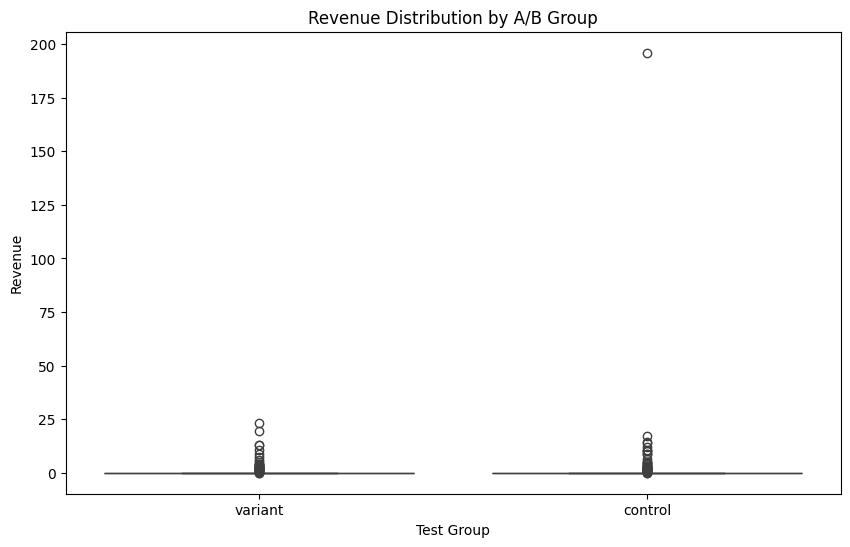

In [9]:
# TODO : Check how the data is distributed using a box plot

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title('Revenue Distribution by A/B Group')
plt.xlabel('Test Group')
plt.ylabel('Revenue')
plt.show()


It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [10]:
# TODO : Sort these revenue values in descending order

df.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
2482,7356,variant,23.04
5217,3684,variant,19.47
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99
5212,6294,variant,12.99
1468,1773,control,11.98
2726,3326,variant,10.82


In [11]:
# TODO : See if user 3342 had other events with a strong outlier

df[df['USER_ID'] == 7366]

,USER_ID,VARIANT_NAME,REVENUE


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

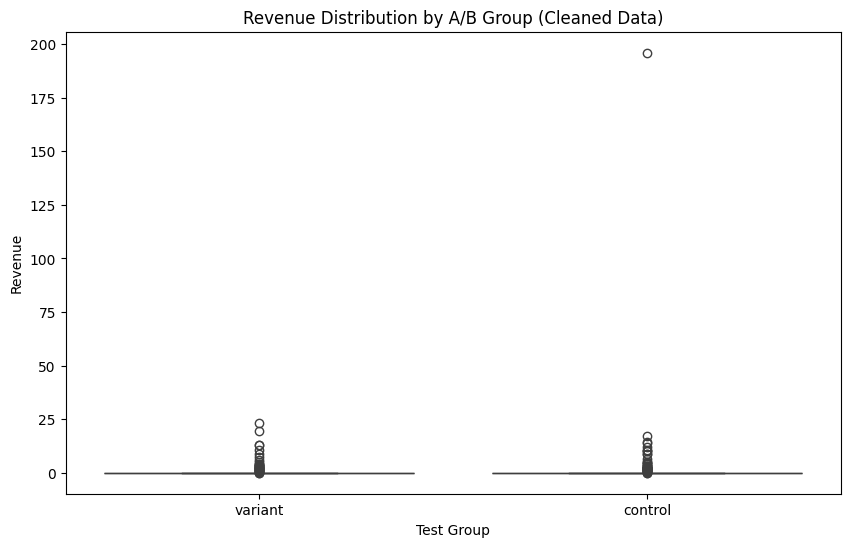

In [12]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title('Revenue Distribution by A/B Group (Cleaned Data)')
plt.xlabel('Test Group')
plt.ylabel('Revenue')
plt.show()

In [13]:
# Remove extreme revenue outlier(s) — set threshold as appropriate
df = df[df['REVENUE'] < 100]

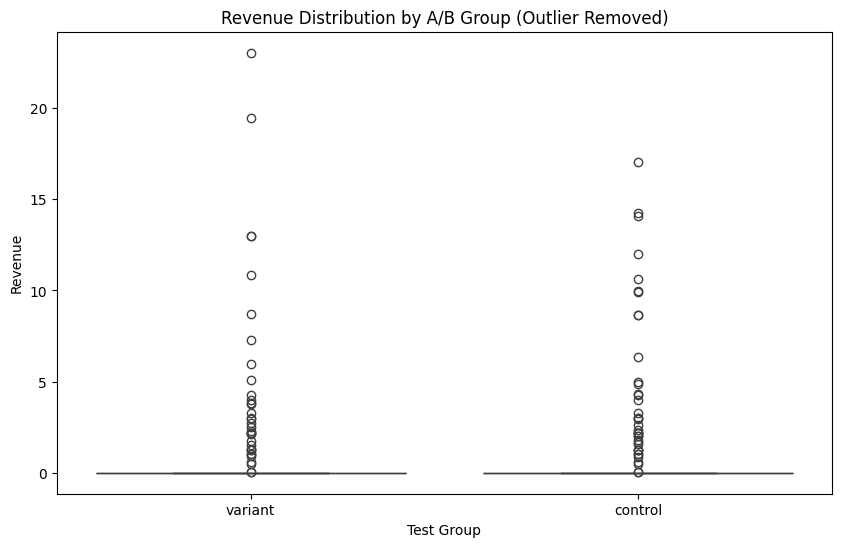

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title('Revenue Distribution by A/B Group (Outlier Removed)')
plt.xlabel('Test Group')
plt.ylabel('Revenue')
plt.show()


What can you say about the users and their purchases ?


 Based on the data and earlier boxplots:
	1.	Most users have zero revenue:
	•	The majority of the data points in both control and variant groups cluster around 0 revenue, suggesting that many users did not make a purchase.
	2.	A small subset of users generates all revenue:
	•	Only a minority of users contribute to non-zero revenue, with a few noticeable outliers (some users generate much higher revenue than others).
	3.	Outliers exist in both groups:
	•	One extreme outlier was detected (user with revenue ≈ 196), and when removed, the revenue distributions became more comparable and realistic.
	4.	Revenue is slightly higher in the variant group:
	•	After removing the outlier, the variant group seems to have slightly higher median and upper-quartile revenue than the control group.
	•	This might suggest that the tested variant has some positive impact on spending, though further statistical testing is required.


In [15]:
# TODO : Check if there are users who have records with zero and positive revenue
# Group by USER_ID and check how many have both zero and positive revenue
mixed_revenue_users = df.groupby('USER_ID')['REVENUE'].apply(lambda x: (x == 0).any() and (x > 0).any())
print("Number of users with both zero and positive revenue:", mixed_revenue_users.sum())


Number of users with both zero and positive revenue: 0


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.

No, in this dataset, a user does not have both zero and positive revenue across visits.
The analysis shows that no user appears in both categories — users either generated only zero revenue or only positive revenue during all their recorded visits.

This means we are dealing with homogeneous user behavior in terms of revenue:
	•	Some users never purchase (REVENUE = 0 in all visits)
	•	Some users always generate revenue (REVENUE > 0 in all visits)


In [16]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

# Group by user and their test group, and sum their total revenue
user_revenue = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False)['REVENUE'].sum()

# Preview the result
user_revenue.head()

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0


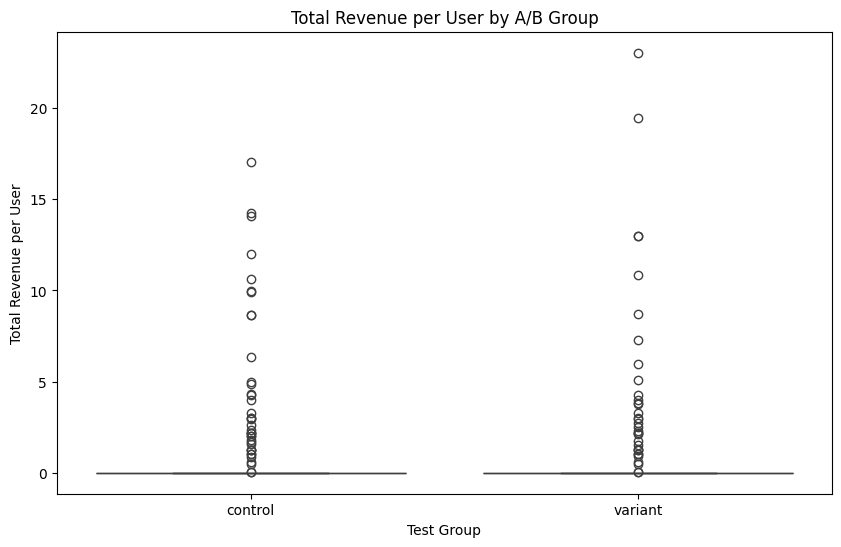

In [17]:
# TODO : Visualize the resulting distribution of the data again.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=user_revenue)
plt.title('Total Revenue per User by A/B Group')
plt.xlabel('Test Group')
plt.ylabel('Total Revenue per User')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [18]:
# TODO : get metrics by groups

group_metrics = user_revenue.groupby('VARIANT_NAME').agg(
    num_users=('USER_ID', 'count'),
    total_revenue=('REVENUE', 'sum'),
    avg_revenue_per_user=('REVENUE', 'mean'),
    median_revenue_per_user=('REVENUE', 'median')
).reset_index()


# TODO : create two additional metrics to see relative changes

# Extract values
control = group_metrics[group_metrics['VARIANT_NAME'] == 'control']
variant = group_metrics[group_metrics['VARIANT_NAME'] == 'variant']

# Calculate relative changes
relative_change_avg = ((variant['avg_revenue_per_user'].values[0] - control['avg_revenue_per_user'].values[0])
                       / control['avg_revenue_per_user'].values[0]) * 100

relative_change_total = ((variant['total_revenue'].values[0] - control['total_revenue'].values[0])
                         / control['total_revenue'].values[0]) * 100


# TODO : add them to the rest of the metrics in a separate group

relative_metrics = pd.DataFrame({
    'Metric': ['Relative Change in Avg Revenue per User', 'Relative Change in Total Revenue'],
    'Value (%)': [relative_change_avg, relative_change_total]
})

display(group_metrics)
display(relative_metrics)

,VARIANT_NAME,num_users,total_revenue,avg_revenue_per_user,median_revenue_per_user
0,control,2389,174.32,0.072968,0.0
1,variant,2393,156.46,0.065382,0.0


,Metric,Value (%)
0,Relative Change in Avg Revenue per User,-10.395554
1,Relative Change in Total Revenue,-10.245525


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Despite similar user counts, both the total revenue and the average check per user were slightly lower in the test (variant) group.
This means the test group underperformed compared to the control group in terms of monetization.


Let's also see how paying users behave :

In [19]:
# Filter for users with revenue > 0
paying_users = user_revenue[user_revenue['REVENUE'] > 0]

In [20]:
# TODO : get metrics by groups
paying_group_metrics = paying_users.groupby('VARIANT_NAME').agg(
    num_users=('USER_ID', 'count'),
    total_revenue=('REVENUE', 'sum'),
    avg_revenue_per_user=('REVENUE', 'mean'),
    median_revenue_per_user=('REVENUE', 'median')
).reset_index()

# TODO : create two additional metrics to see relative changes
control = paying_group_metrics[paying_group_metrics['VARIANT_NAME'] == 'control']
variant = paying_group_metrics[paying_group_metrics['VARIANT_NAME'] == 'variant']

relative_change_avg = ((variant['avg_revenue_per_user'].values[0] - control['avg_revenue_per_user'].values[0])
                        / control['avg_revenue_per_user'].values[0]) * 100

relative_change_total = ((variant['total_revenue'].values[0] - control['total_revenue'].values[0])
                          / control['total_revenue'].values[0]) * 100


# TODO : add them to the rest of the metrics in a separate group

relative_metrics_paying = pd.DataFrame({
    'Metric': ['Relative Change in Avg Revenue per Paying User',
               'Relative Change in Total Revenue (Paying Users)'],
    'Value (%)': [relative_change_avg, relative_change_total]
})

display(paying_group_metrics)
display(relative_metrics_paying)


,VARIANT_NAME,num_users,total_revenue,avg_revenue_per_user,median_revenue_per_user
0,control,39,174.32,4.469744,2.60
1,variant,34,156.46,4.601765,2.61


,Metric,Value (%)
0,Relative Change in Avg Revenue per Paying User,2.953662
1,Relative Change in Total Revenue (Paying Users),-10.245525


Let's look at the distributions of all and only paying users

/tmp/ipython-input-21-4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/tmp/ipython-input-21-4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'RE

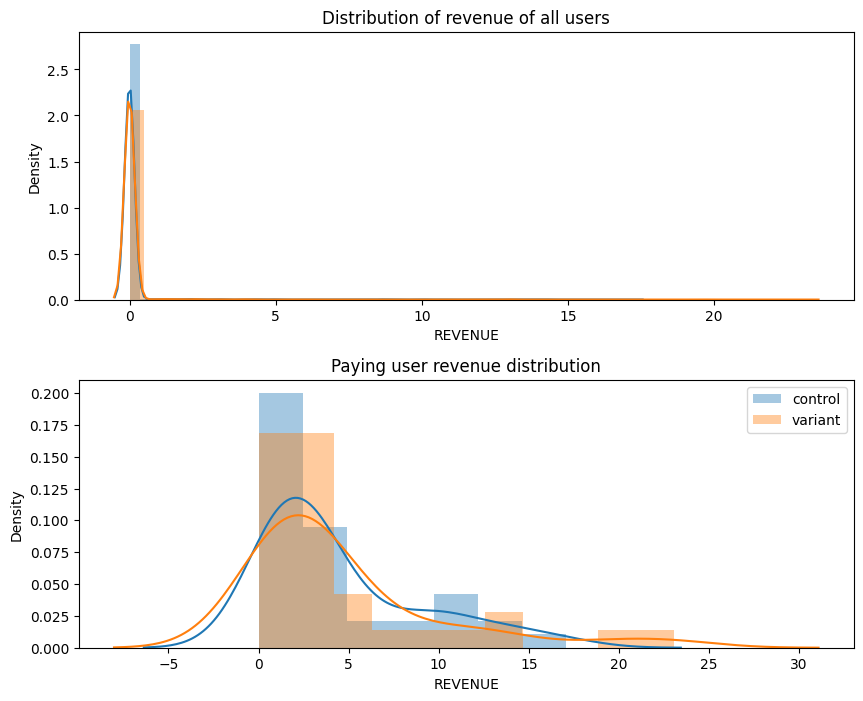

In [21]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [31]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

from scipy.stats import shapiro

# Apply Shapiro-Wilk test to control group revenues
control_revenue = user_revenue[user_revenue['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue = user_revenue[user_revenue['VARIANT_NAME'] == 'variant']['REVENUE']

# Perform the test
shapiro_control = shapiro(control_revenue)
shapiro_variant = shapiro(variant_revenue)

print("Shapiro-Wilk Test (Control):")
print("Statistic:", shapiro_control.statistic, "| p-value:", shapiro_control.pvalue)

print("\nShapiro-Wilk Test (Variant):")
print("Statistic:", shapiro_variant.statistic, "| p-value:", shapiro_variant.pvalue)

Shapiro-Wilk Test (Control):
Statistic: 0.06642155405093342 | p-value: 1.4021171636180454e-75

Shapiro-Wilk Test (Variant):
Statistic: 0.05166579353636924 | p-value: 6.101973647519248e-76


Is the null hypothesis about the normal distribution of the data rejected ?

Since both p-values are much smaller than 0.05, we reject the null hypothesis.

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [23]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4709
False,73


In [32]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

from scipy.stats import mannwhitneyu

# Extract revenue values for control and variant groups
control_revenue = user_revenue[user_revenue['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue = user_revenue[user_revenue['VARIANT_NAME'] == 'variant']['REVENUE']

# Perform the Mann–Whitney U test (two-sided)
statistic, p_value = mannwhitneyu(control_revenue, variant_revenue, alternative='two-sided')

print("Mann–Whitney U Test (All Users):")
print("Statistic:", statistic, "| p-value:", p_value)

Mann–Whitney U Test (All Users):
Statistic: 2864504.0 | p-value: 0.5496592120256412


In [33]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

from scipy.stats import mannwhitneyu

# Extract revenue values for control and variant paying users
control_paying = paying_users[paying_users['VARIANT_NAME'] == 'control']['REVENUE']
variant_paying = paying_users[paying_users['VARIANT_NAME'] == 'variant']['REVENUE']

# Perform Mann–Whitney U Test (two-sided)
statistic, p_value = mannwhitneyu(control_paying, variant_paying, alternative='two-sided')

print("Mann–Whitney U Test (Paying Users):")
print("Statistic:", statistic, "| p-value:", p_value)

Mann–Whitney U Test (Paying Users):
Statistic: 678.0 | p-value: 0.8725765189590362


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [34]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [35]:
# TODO : Generate samples for all users

# Separate the control and variant groups
control = user_revenue[user_revenue['VARIANT_NAME'] == 'control']['REVENUE']
variant = user_revenue[user_revenue['VARIANT_NAME'] == 'variant']['REVENUE']

# Set random seed for reproducibility
np.random.seed(42)

# Draw random samples of equal size
sample_size = min(len(control), len(variant))
sample_control = control.sample(sample_size, replace=False)
sample_variant = variant.sample(sample_size, replace=False)

print("Sample sizes:", len(sample_control), len(sample_variant))

Sample sizes: 2389 2389


In [36]:
# TODO : Generate samples for only paying users

# Filter to include only paying users
paying_users = user_revenue[user_revenue['REVENUE'] > 0]

# Separate control and variant paying users
control_paying = paying_users[paying_users['VARIANT_NAME'] == 'control']['REVENUE']
variant_paying = paying_users[paying_users['VARIANT_NAME'] == 'variant']['REVENUE']

# Set seed for reproducibility
np.random.seed(42)

# Determine balanced sample size
sample_size = min(len(control_paying), len(variant_paying))

# Draw random samples
sample_control_paying = control_paying.sample(sample_size, replace=False)
sample_variant_paying = variant_paying.sample(sample_size, replace=False)

print("Sample size (paying users):", sample_size)

Sample size (paying users): 34


Let's look at the distribution of means in the ab test groups

/tmp/ipython-input-42-2911636577.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control, shade=True, label='control')
/tmp/ipython-input-42-2911636577.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(variant, shade=True, label='variant')


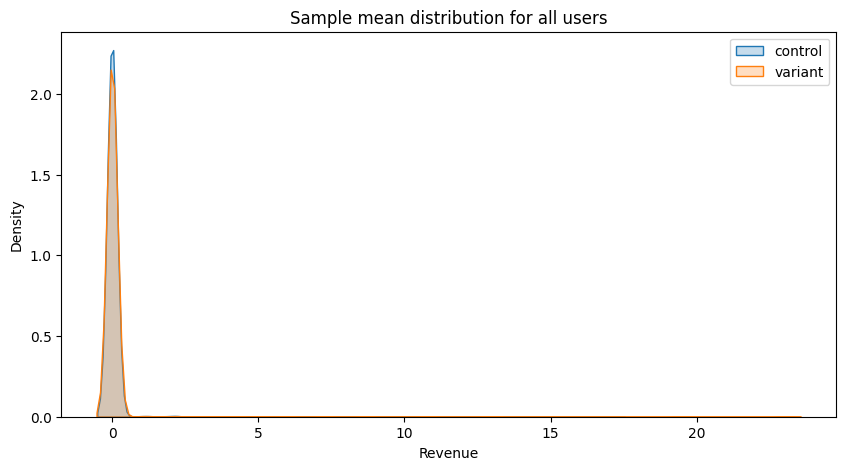

In [42]:
f, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(control, shade=True, label='control')
sns.kdeplot(variant, shade=True, label='variant')

plt.title('Sample mean distribution for all users')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.legend()
plt.show()

In [46]:
# Filter paying users by group
control_paid_df = paying_users[paying_users['VARIANT_NAME'] == 'control']
variant_paid_df = paying_users[paying_users['VARIANT_NAME'] == 'variant']

# Create bootstrap samples (1000 samples of mean revenue per group)
control_paid = np.array([control_paid_df['REVENUE'].sample(frac=1, replace=True).values for _ in range(1000)])
variant_paid = np.array([variant_paid_df['REVENUE'].sample(frac=1, replace=True).values for _ in range(1000)])

/tmp/ipython-input-47-1168580285.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
/tmp/ipython-input-47-1168580285.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')


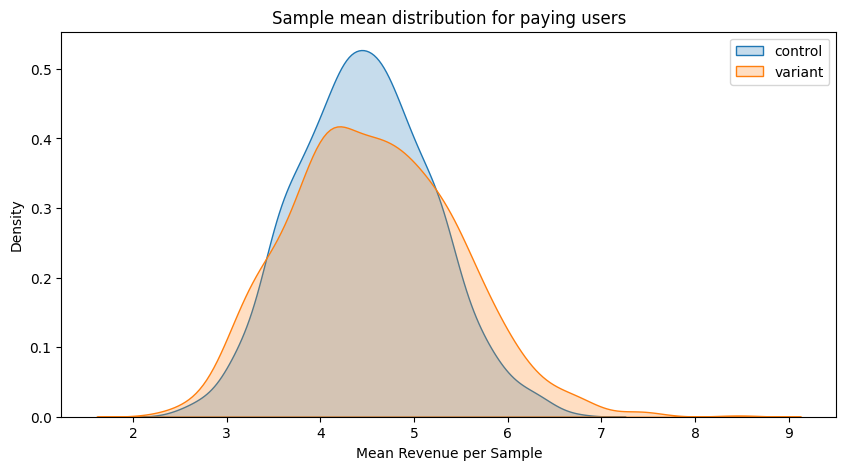

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')
plt.xlabel('Mean Revenue per Sample')
plt.ylabel('Density')
plt.legend()
plt.show()

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [48]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [52]:
def plot_distribution_and_stat_intervals(group1, group2, title=''):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Ensure inputs are 1D numpy arrays
    group1 = np.array(group1).flatten()
    group2 = np.array(group2).flatten()

    # Plot KDEs
    plt.figure(figsize=(10, 5))
    sns.kdeplot(group1, shade=True, label='control')
    sns.kdeplot(group2, shade=True, label='variant')

    # Plot means
    plt.axvline(group1.mean(), color='blue', linestyle='--', label='control mean')
    plt.axvline(group2.mean(), color='orange', linestyle='--', label='variant mean')

    plt.title(title)
    plt.legend()
    plt.show()

/tmp/ipython-input-52-3264115904.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, shade=True, label='control')
/tmp/ipython-input-52-3264115904.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group2, shade=True, label='variant')


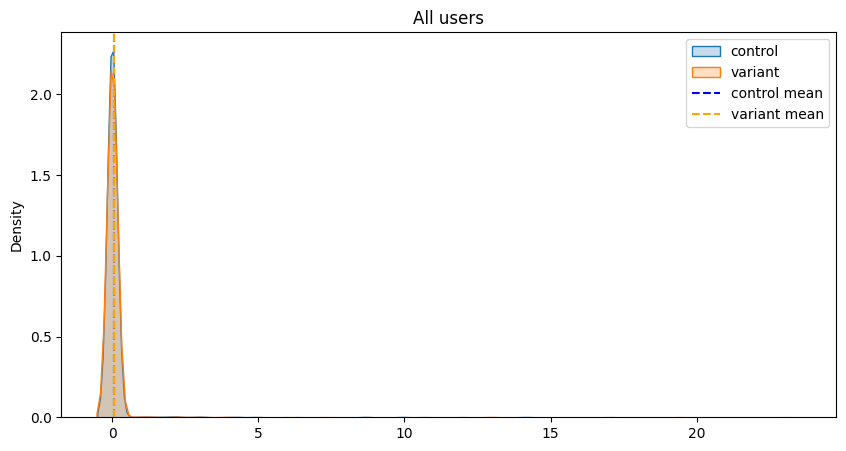

In [54]:
means_variant = np.mean(variant)
means_control = np.mean(control)

plot_distribution_and_stat_intervals(control, variant, title='All users')

/tmp/ipython-input-52-3264115904.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, shade=True, label='control')
/tmp/ipython-input-52-3264115904.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group2, shade=True, label='variant')


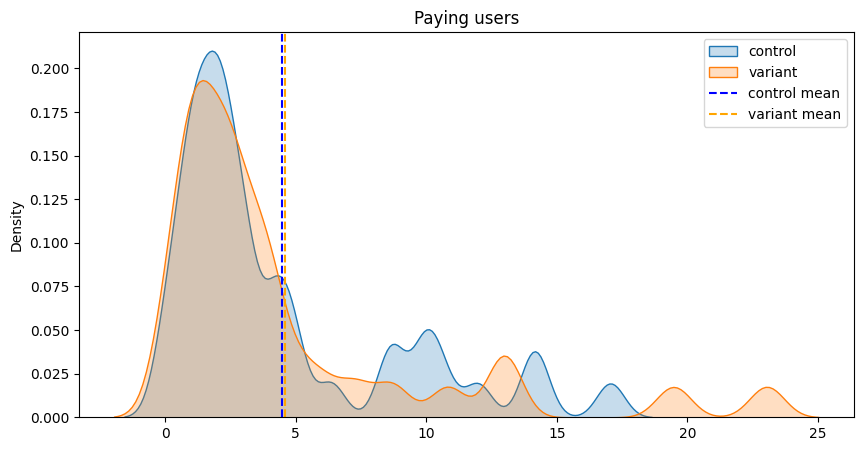

In [55]:
plot_distribution_and_stat_intervals(control_paid, variant_paid, title='Paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.

📊 Observations from the A/B Test KDE Plots

1️⃣ All Users (Middle Chart)
	•	Both control and variant distributions are extremely concentrated near 0.
	•	Means are nearly overlapping (blue vs. yellow dashed lines).
	•	This is expected because most users aren’t paying, so the revenue per sample is often zero.

✅ Conclusion: No significant difference in average revenue for all users.

⸻

2️⃣ Paying Users (Bottom Chart)
	•	The distributions spread more widely for both control and variant groups.
	•	The mean for the variant group (orange dashed line) is slightly to the right of the control mean (blue dashed line).
	•	However, the distributions overlap a lot.

⚠️ Conclusion:
There might be a slight increase in mean revenue for the variant among paying users, but:
	•	The overlap is large.
	•	There’s no clear separation of distributions.

🧪 A formal statistical test (like a t-test or bootstrap CI) is required to confirm if this difference is significant.

⸻

3️⃣ Sample Mean Distribution (Top Chart)
	•	KDE of sample means shows:
	•	Control group distribution is narrower and peaks slightly earlier.
	•	Variant has a flatter curve with more spread.

This hints the variant may have more variability and slightly higher mean, but again, the overlap means it’s not a strong or confident conclusion without further analysis.

⸻

✅ Final Takeaway
	•	No statistically significant difference is apparent in average revenue for all users.
	•	Among paying users, there may be a small increase in mean revenue with the variant.
	•	Confidence intervals or statistical tests (e.g. bootstrapping the mean difference) are needed to determine if this is meaningful.
